# How to get the analysis at data points

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random

# Data reading
Download the data file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file is a space-separated file containing data based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).

In [6]:
mkpath("data")
fname = "./data/Salinity.bigfile"

if !isfile(fname)
    download("https://dox.ulg.ac.be/index.php/s/k0f7FxA7l5FIgu9/download",fname)
else
    @info("Data file already downloaded")
end

┌ Info: Data file already downloaded
└ @ Main In[6]:7


Load the data

In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);

┌ Info: Loading data from 'big file' ./data/Salinity.bigfile
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/2Jn3u/src/load_obs.jl:10


In [23]:
# surface values for the month January
sel = (obsdepth .< 10)
x = (obslon[sel], obslat[sel]);
v = obsval[sel] .- mean(obsval[sel]);
@info("$(length(findall(sel))) selected data points")

┌ Info: 13600 selected data points
└ @ Main In[23]:5


We create a grid around the Black Sea.

In [47]:
dx = dy = 0.1
lonr = 27:dx:42.
latr = 40:dy:47.5
mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr);

In [48]:
bathname = "data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[48]:5


In [49]:
bx,by,b = load_bath(bathname,true,lonr,latr);

In [50]:
mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

## Make the analysis

In [51]:
len=0.3
epsilon2=1.0;
fi, s = DIVAndrun(mask, (pm,pn), (xi,yi), x , v, len, epsilon2);

### Analysis plot + data

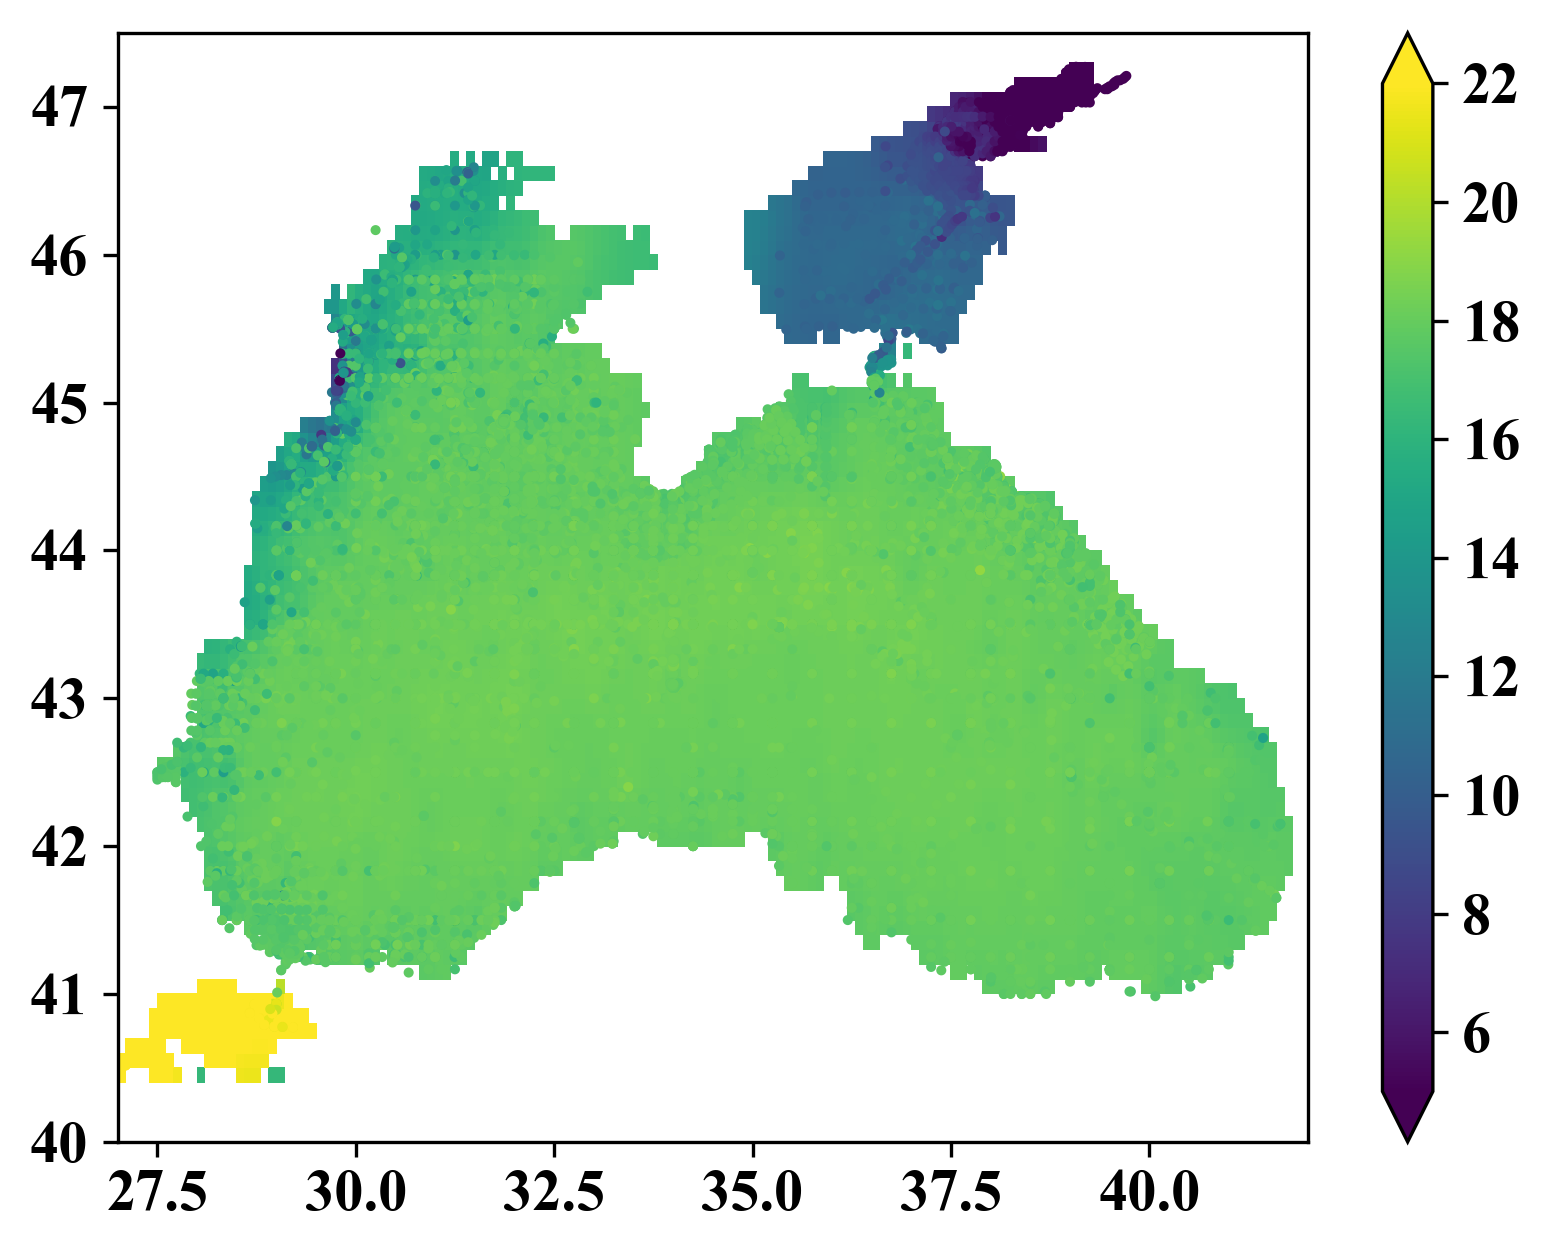

In [52]:
Smin = 5.
Smax = 22.
PyPlot.pcolormesh(lonr, latr, transpose(fi) .+ mean(obsval[sel]), vmin=Smin, vmax=Smax)
PyPlot.scatter(obslon[sel], obslat[sel], s=2, c=obsval[sel], vmin=Smin, vmax=Smax)
PyPlot.colorbar(extend="both")
PyPlot.show()

## Compute residuals
The function `DIVAnd_residualobs` computes the residuals at the real data location, meaning that the artificial data points possibly used with the constrains are not taken into account.

In [53]:
dataresidual = DIVAnd_residualobs(s, fi);

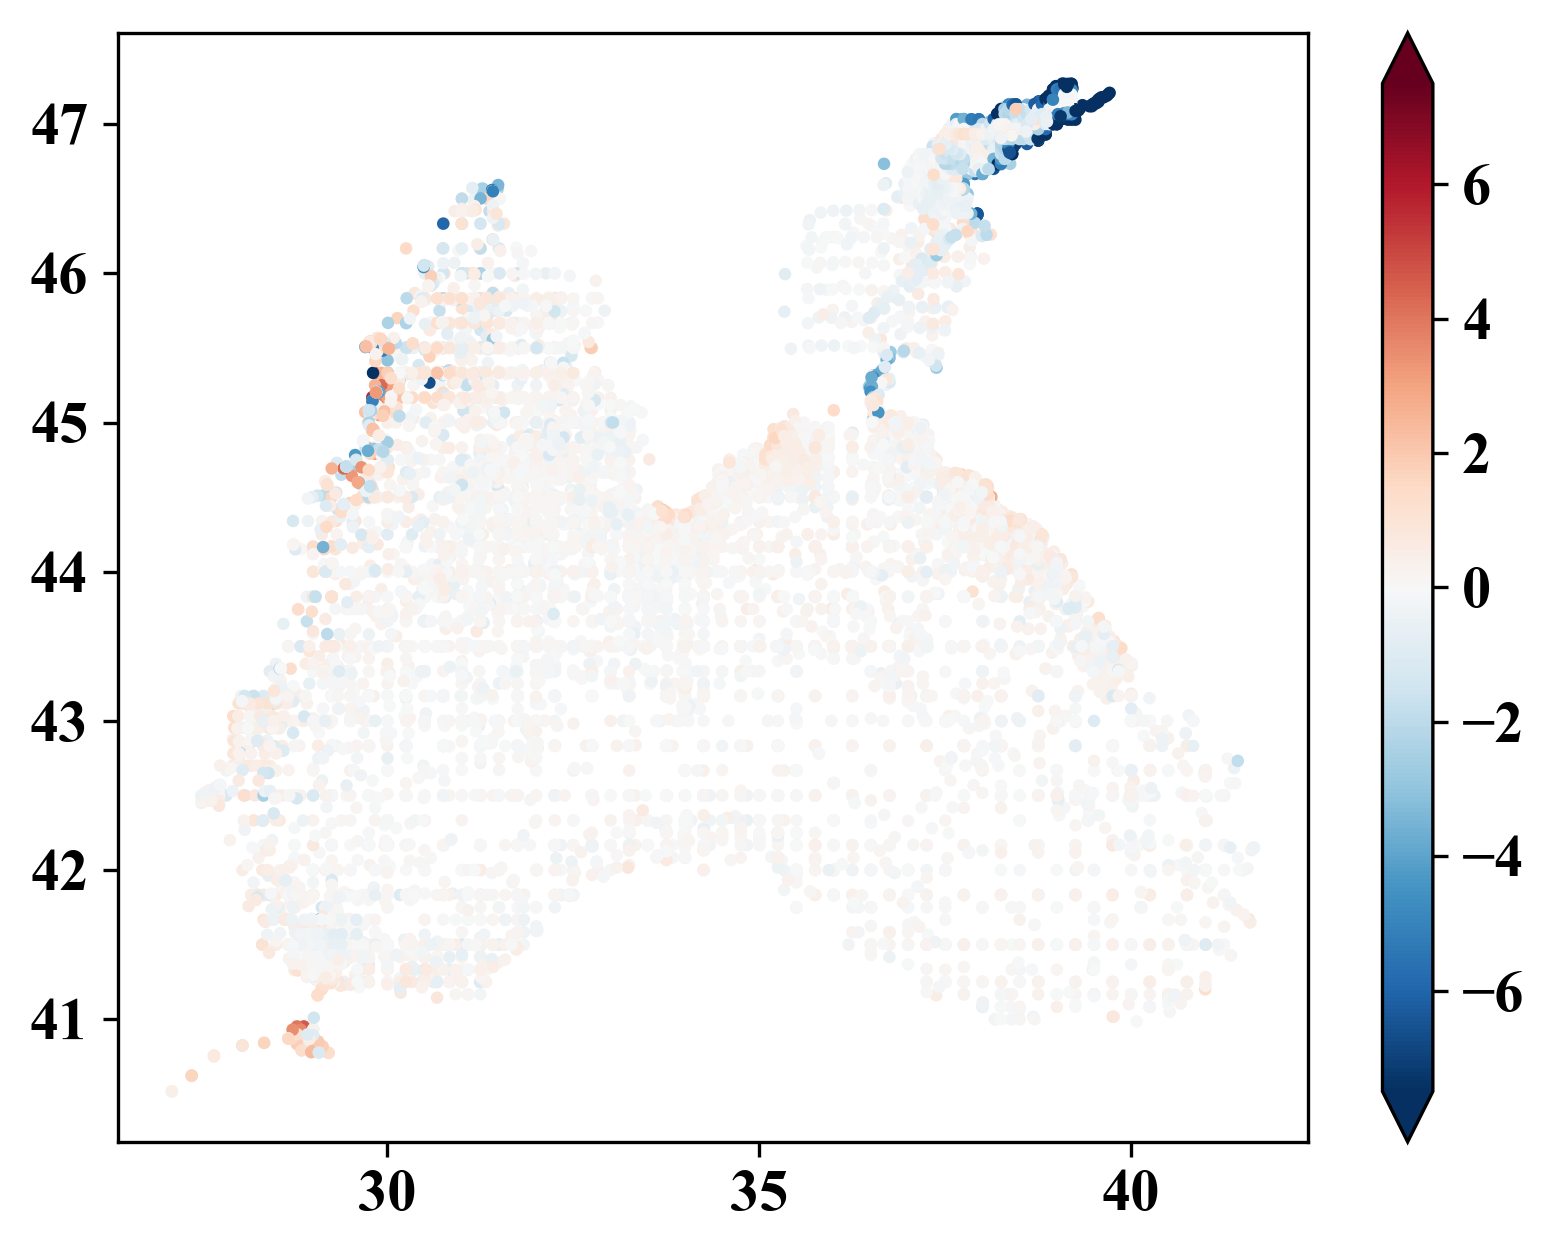

In [56]:
PyPlot.scatter(obslon[sel], obslat[sel], s=4, c=dataresidual, cmap=PyPlot.cm.RdBu_r, vmin=-7.5, vmax=7.5)
PyPlot.colorbar(extend="both")
PyPlot.show()

## Analysis at data points

The residuals are defined as the difference between the observations and the analysis at the observation locations, hence the analysis at data points can be recovered as:

In [58]:
fi_obs = obsval[sel] - dataresidual;
@show size(fi_obs);

size(fi_obs) = (13600,)


### Plot obs vs. analysis at data points
They look similar, we take a tighter interval for the colorbar to make the difference more visible.

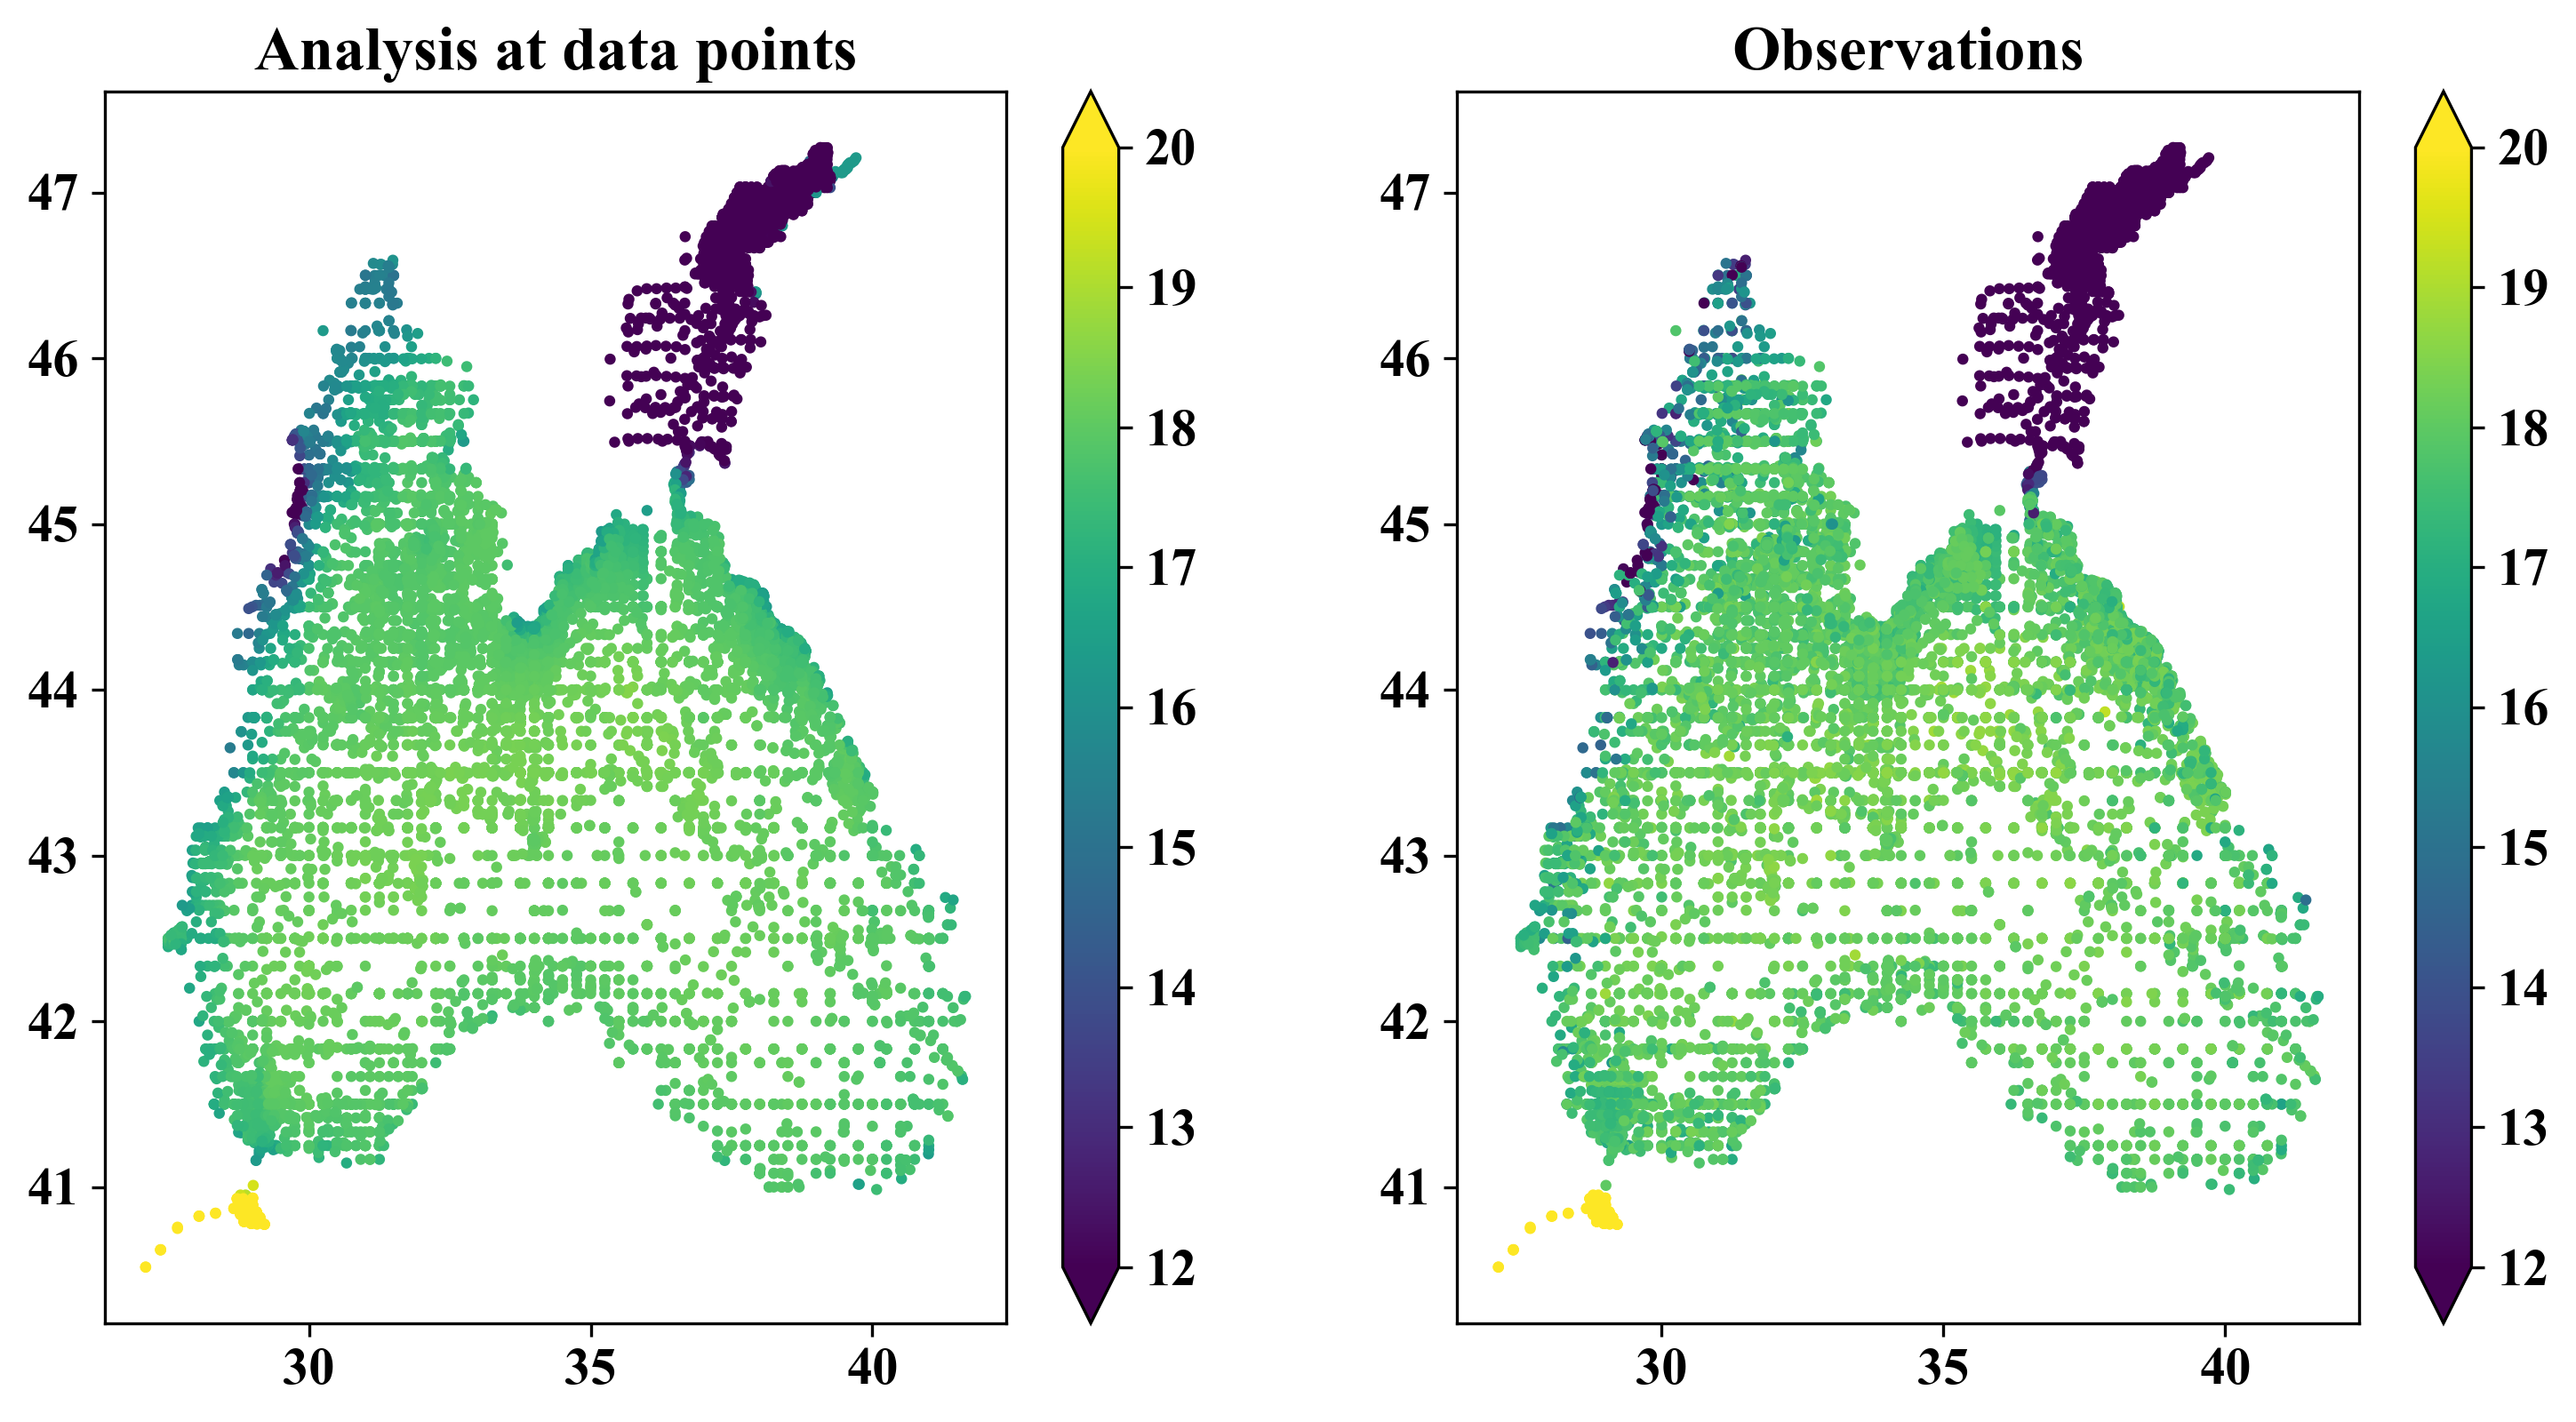

In [67]:
PyPlot.figure(figsize=(12, 6))
PyPlot.subplot(121)
PyPlot.scatter(obslon[sel], obslat[sel], s=4, c=fi_obs, vmin=12., vmax=20.)
PyPlot.colorbar(extend="both")
PyPlot.title("Analysis at data points")
PyPlot.subplot(122)
PyPlot.scatter(obslon[sel], obslat[sel], s=4, c=obsval[sel], vmin=12., vmax=20.)
PyPlot.colorbar(extend="both")
PyPlot.title("Observations")
PyPlot.show()